In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

## Read images

In [2]:
#Function to load all the images that are inside a directory
def load_ml_data(data_directory):
    #We create an array with the directories that are inside the data_directory
    dirs = [d for d in os.listdir(data_directory)
            if os.path.isdir(os.path.join(data_directory,d))]
    
    #We initialize two lists, one to store images and the other for labels
    labels = []
    images = []
    
    #We go through each folder within the dirs array
    for d in dirs:
        sub_dir = os.path.join(data_directory, d)
        file_names = [os.path.join(sub_dir, f)
                     for f in os.listdir(sub_dir)
                     if f.endswith(".png")] #We are only going to read those files with the extension .png
        
        #The label will correspond to the name of the folder that contains the images
        for f in file_names:
            img = cv2.imread(f)
            #To train a CNN all images must be the same size
            images.append(cv2.resize(img,(112,112))) #Resize the images
            labels.append(int(d))
        
    return images, labels

In [3]:
#Prepare routes
main_dir = "../data/archive/Dataset of Breast mammography images_out/"
train_data_dir = os.path.join(main_dir, "train")
validation_data_dir = os.path.join(main_dir, "val")

In [4]:
train_images, train_labels = load_ml_data(train_data_dir)
validation_images, validation_labels =  load_ml_data(validation_data_dir)

In [5]:
#Transform lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

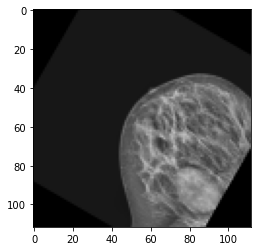

In [6]:
plt.imshow(train_images[0]) #This is a preliminar image

### These images are not yet processed, even so the model can be trained with these images, the accuracy will be low.
### It is advisable to work with previously processed images.

## Data analysis

In [ ]:
#The number of uniques labels
len(set(train_labels)), len(set(validation_labels)) 

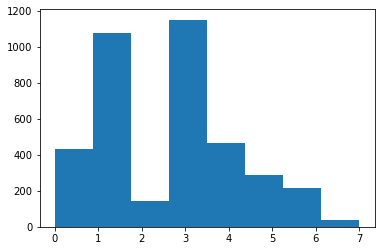

In [8]:
#With the histogram we can observe the distribution of images with respect to their labels.
plt.hist(train_labels, len(set(train_labels)))
plt.show()

In [9]:
import random 

In [10]:
rand_breast = random.sample(range(0, len(train_labels)), 6)

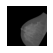

shape: (112, 112, 3), min: 0, max: 127


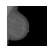

shape: (112, 112, 3), min: 0, max: 133


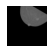

shape: (112, 112, 3), min: 0, max: 128


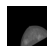

shape: (112, 112, 3), min: 0, max: 137


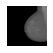

shape: (112, 112, 3), min: 0, max: 134


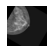

shape: (112, 112, 3), min: 0, max: 205


In [11]:
#We are going to plot 6 images randomly
for i in range(len(rand_breast)):
    plt.subplot(1,6,i+1)
    plt.axis("off")
    plt.imshow(train_images[rand_breast[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(train_images[rand_breast[i]].shape,
                                             train_images[rand_breast[i]].min(),
                                             train_images[rand_breast[i]].max()))

### The values of the pixels are in the range of [0, 255], when we training a neural network it is recommended to normalize the images, that means, change the range to [0, 1]

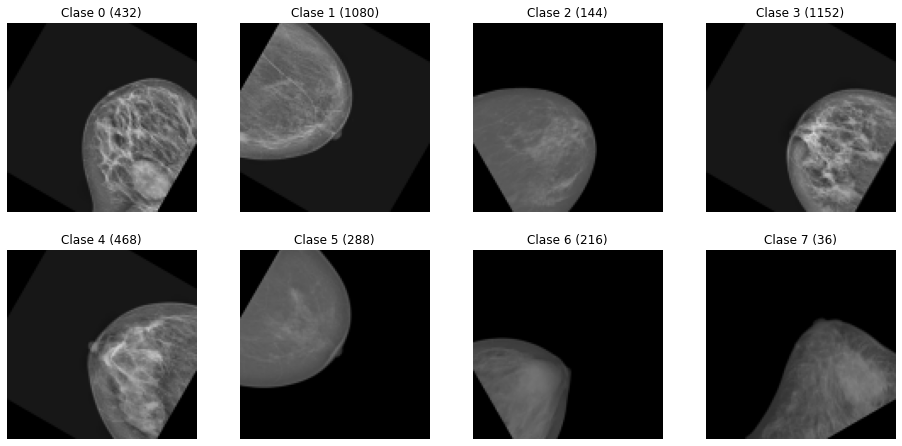

In [12]:
#Here i'm only showing an image corresponding to each class and the number of images in it.
unique_labels = set(train_labels)

plt.figure(figsize=(16,16))
i = 1
for label in unique_labels:
    temp_im = train_images[list(train_labels).index(label)]
    plt.subplot(4,4, i)
    plt.axis("off")
    plt.title("Clase {0} ({1})".format(label, list(train_labels).count(label)))
    i +=1
    plt.imshow(temp_im)
plt.show()

## Normalized images

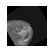

shape: (112, 112, 3), min: 0.0, max: 0.8884462118148804


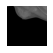

shape: (112, 112, 3), min: 0.0, max: 0.4940239191055298


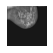

shape: (112, 112, 3), min: 0.06772908568382263, max: 0.8804781436920166


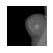

shape: (112, 112, 3), min: 0.0, max: 0.5737051963806152


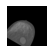

shape: (112, 112, 3), min: 0.0, max: 0.541832685470581


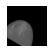

shape: (112, 112, 3), min: 0.0, max: 0.5219123363494873


In [13]:
#Normalize images with the help of the OpenCV normalize () method
training_data = cv2.normalize(train_images, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
validation = cv2.normalize(validation_images, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

rand_breast = random.sample(range(0, len(training_data)), 6)
for i in range(len(rand_breast)):
    plt.subplot(1,6,i+1)
    plt.axis("off")
    plt.imshow(training_data[rand_breast[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(training_data[rand_breast[i]].shape,
                                             training_data[rand_breast[i]].min(),
                                             training_data[rand_breast[i]].max()))

## Image classifier 

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

K.clear_session() #If there is a tensorflow process running in the background, we end it with this command.

In [15]:
model = models.Sequential() #Our network will be sequential
#Our first layer will be a convolution with 32 filters of size 3x3
#The size of the input is specified in the first layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)))
#Layer MaxOoling
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [17]:
#We create a dimension that contains all the information of our neural network.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#We specify the number of classes
model.add(layers.Dense(8, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [19]:
#Build model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#We train the model with training_data, and validate with validation_data
history = model.fit(training_data, train_labels, epochs=10, 
                    validation_data=(validation, validation_labels))

Epoch 1/10
120/120 [==============================] - 161s 1s/step - loss: 1.9748 - accuracy: 0.3008 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 2/10
120/120 [==============================] - 159s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 3/10
120/120 [==============================] - 162s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 4/10
120/120 [==============================] - 161s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 5/10
120/120 [==============================] - 161s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 6/10
120/120 [==============================] - 165s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019
Epoch 7/10
120/120 [==============================] - 159s 1s/step - loss: 1.9721 - accuracy: 0.3019 - val_loss: 1.9721 - val_accuracy: 0.3019

In [21]:
#In order not to have to train the neural network every time we need it, we are going to store the model in a file
dire = "../model/"

if not os.path.exists(dire):
    os.mkdir(dire)
history.model.save("../model/model.h5")
history.model.save_weights("../model/weigths.h5")